# MIT JLab Project: Detect GW with LIGO open data
Author: Jing Wang <br>
Date: Sep 29 2020

* This tutorial is developed for MIT Junior lab project "Detect GW with LIGO open data".
* A manual of this project can be found [here](http://www.mit.edu/~jwang011/LIGOmanualJLab.pdf).
* This tutorial is based on the material on [Gravitational Wave Open Science Center](https://www.gw-openscience.org/) and the tutorial from Professor Philip Harris.
* Some codes are hidden, and you need to build it by yourself.
* <span style="color:#CF7A17;font-weight:bold">Orange bold text</span> hightlights the questions you need to answer or codes you need to develop.

## Introduction
The existence of gravitational waves (GW) was first predicted by Albert Einstein in his General Theory of Relativity in 1916.
He found that the linearized weak-field equations had wave solutions.
By analogy to electromagnetism, time variation of the mass quadrupole moment of the source is expected to lead to transverse waves of spatial strain.
The existence of GW was first demonstrated in 1974 by the discovery of a binary system composed of a pulsar in orbit around a neutron star by Hulse and Taylor [[1]](https://ui.adsabs.harvard.edu/abs/1975ApJ...195L..51H/abstract).
However, direct detections of GW did not arrive until 2016.
In that year, The LIGO (The Laser Interferometer Gravitational-Wave Observatory) collaboration reported the first direct detection of GW from a binary black hole system merging to form a single black hole [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102).
The observations reported in this paper and futher GW detections would provide new tests of generay relativity in its strong-field regime, and GW observations have become an important new means to learn about the Universe.

In this project, you will reproduce the results reported in [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102) with LIGO open data. This tutorial will show how to analyze a particular GW event GW150914. In the tutorial, you will find how to download the data collected by Handford Observatory starting from Mon Sep 14 09:16:37 GMT 2015, plot the strain, whiten and filter the strain, plot a q-transform of the data, and extract the features of the source with a simple analytic model. After getting familiar with the basic analysis methods, you need to explore more events, check the consistence between detectors, match numerical relativity waveform template to extract accurate information of the source, compare with LIGO published results, and develop a machinery to search GW event within a long time range.

## Preparation

### Download the data

    wget -P data https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126257415-4096.hdf5

All the available open data can be found on [Gravitational Wave Open Science Center](https://www.gw-openscience.org/eventapi/html/allevents/). In this tutorial, we take event GW150914 data as example. In the name of this particular data file:
  * "GW150914" means September 14, 2015 
  * "H-H1" means that the data come from the LIGO Hanford Observatory site and the LIGO "H1" datector;
  * "1126257414-4096" means the data starts at GPS time 1126257414 (Mon Sep 14 09:16:37 GMT 2015), duration 4096 seconds;
    * NOTE: GPS time is number of seconds since Jan 6, 1980 GMT. See http://www.oc.nps.edu/oc2902w/gps/timsys.html.

### Load libraries

In [40]:
#----------------------------------------------------------------
# Load libraries
#----------------------------------------------------------------
import numpy as np
import math
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot

import astropy.units as units

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

import os

%matplotlib inline

### Set input file and parameters

In [3]:
#----------------------------------------------------------------
# Set parameters
#----------------------------------------------------------------
#Parameters for data to analyze now
fn = 'data/H-H1_GWOSC_16KHZ_R1-1126257415-4096.hdf5' # data file
tevent = 1126259462.422 # Mon Sep 14 09:50:45 GMT 2015
evtname = 'GW150914' # event name

detector = 'H1' # detector: L1 or H1

#Parameters for data to compare to later
fn2 = 'data/L-L1_GWOSC_16KHZ_R1-1126257415-4096.hdf5'
detector2 = 'L1'

### Load data

In [4]:
#----------------------------------------------------------------
# Load LIGO data
#----------------------------------------------------------------
strain = TimeSeries.read(fn, format='hdf5.losc')
center = int(tevent)
strain = strain.crop(center-16, center+16)

#For L1 data:
strain2 = TimeSeries.read(fn2, format='hdf5.losc')
strain2 = strain2.crop(center-16, center+16) #Detectors separated by only around 0.01ls

## Analysis on a known event

### First look at data: raw time-series data

<Figure size 432x288 with 0 Axes>

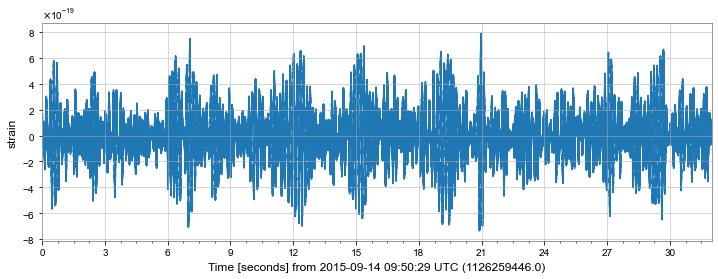

In [5]:
#----------------------------------------------------------------
# Show LIGO strain vs. time
#----------------------------------------------------------------
plt.figure()
strain.plot()
plt.ylabel('strain')
plt.show()

The data are dominated by low frequency noise, and there is no way to see a signal here.

### Data in the Fourier domain: ASDs

Plotting these data in the Fourier domain gives us an idea of the frequency content of the data. A way to visualize the frequency content of the data is to plot the amplitude spectral density, ASD. The ASDs are the square root of the power spectral densities (PSDs), which are averages of the square of the fast fourier transforms (FFTs) of the data. They are an estimate of the "strain-equivalent noise" of the detectors versus frequency, which limit the ability of the detectors to identify GW signals.

<Figure size 432x288 with 0 Axes>

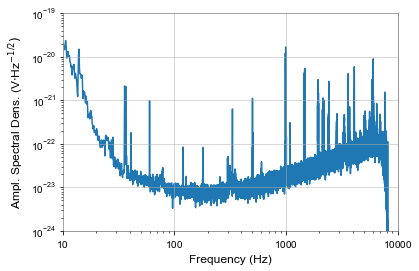

In [6]:
#----------------------------------------------------------------
# Obtain the power spectrum density PSD / ASD
#----------------------------------------------------------------

asd = strain.asd(fftlength=8)

plt.clf()
asd.plot()
plt.xlim(10, 10000)
plt.ylim(1e-24, 1e-19)
plt.ylabel('Ampl. Spectral Dens. (V$\cdot$Hz$^{-1/2})$')
plt.xlabel('Frequency (Hz)')
plt.show()

You can see strong spectral lines in the data. They are all of instrumental origin. Some are engineered into the detectors (mirror suspension resonances at ~500 Hz and harmonics, calibration lines, control dither lines, etc) and some (60 Hz and harmonics) are unwanted. We'll return to these, later.

You can't see the signal in this plot, since it is relatively weak and less than a second long, while this plot averages over 32 seconds of data. So this plot is entirely dominated by instrumental noise.

### Whitening data
From the ASD above, we can see that noise fluctuations are much larger at low and high frequencies and near spectral lines. We can "whiten" the data, suppressing the extra noise at low frequencies and at the spectral lines, to better see the weak signals in the most sensitive band.

<Figure size 432x288 with 0 Axes>

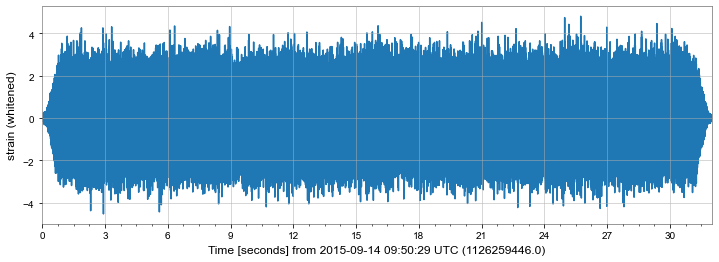

In [7]:
#----------------------------------------------------------------
# Whitening data
#----------------------------------------------------------------

white_data = strain.whiten()

plt.clf()
white_data.plot()
plt.ylabel('strain (whitened)')
plt.show()

#Doing the same for L1 data
white_data2 = strain2.whiten()

We seem to see potential signal now... (maybe?) It's still not good enought, next we will apply a band-pass filter to reject high frequency noise.

### Bandpassing filter
The macro below shows you a framework to do bandpassing.<br>
<span style="color:#CF7A17;font-weight:bold">What you need to do: play with the filter thresholds (bandpass_low and bandpass_high), and find a window leading to a clear signal.</span>

In [9]:
#UPDATE: After doing some manual messing around, got lucky; decent signal
#in just a few tries

#----------------------------------------------------------------
# Bandpass filter threshold finder
#----------------------------------------------------------------

#Idea 1: Brute force different allowed bands of .1, .2, ... , 1 kHz

#Idea 2: Binary search the space of allowed bands, starting from wide,
#with filter remaining at least 1kHz in width

#Try maximizing the ratio of largest value of squared deviation from 0 to
#average value of squared deviation from 0, see if good signal result


In [8]:
bandpass_low = 30 #reject noise order of magnitude greater than sensitive region
bandpass_high = 300 #expect merger to end around here

<Figure size 432x288 with 0 Axes>

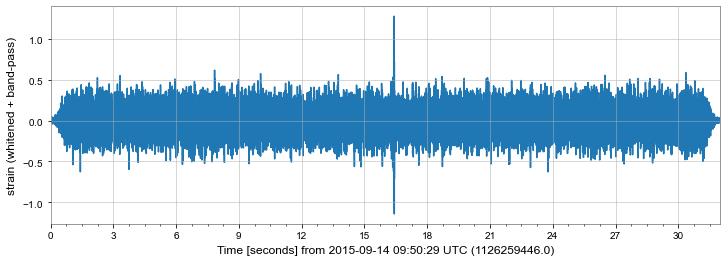

In [9]:
#----------------------------------------------------------------
# Bandpass filtering
#----------------------------------------------------------------

white_data_bp = white_data.bandpass(bandpass_low, bandpass_high)

plt.clf()
white_data_bp.plot()
plt.ylabel('strain (whitened + band-pass)')
plt.show()

#Doing the same for L1 data
white_data_bp2 = white_data2.bandpass(bandpass_low, bandpass_high)

With the proper bandpass_low and bandpass_high set, we see a significant signal! Next let's zoom in.

<Figure size 432x288 with 0 Axes>

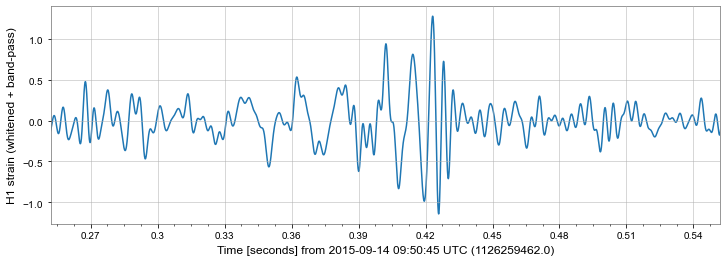

In [10]:
#H1 signal
plt.clf()
white_data_bp.plot()
plt.ylabel('H1 strain (whitened + band-pass)')
plt.xlim(tevent-0.17, tevent+0.13)
plt.show()

## H1 and L1 comparison
We would like to compare the signals measured at the H1 (used above) and L1 detectors. The detectors were built such that their interferometer arms are roughly parallel, so we may expect the signals to be similar.

<Figure size 432x288 with 0 Axes>

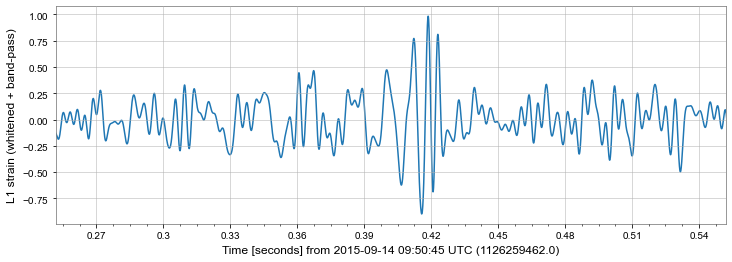

In [12]:
#L1 signal
plt.clf()

plt.show()

<Figure size 432x288 with 0 Axes>

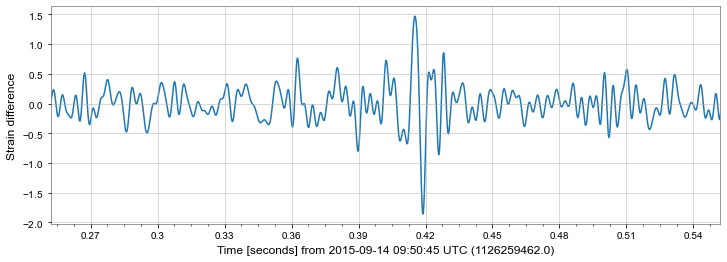

In [13]:
#Difference
plt.clf()
delta = white_data_bp - white_data_bp2
delta.plot()
plt.ylabel('Strain difference')
plt.xlim(tevent-0.17, tevent+0.13)
plt.show()

The difference is quite large, but the signals do look similar. Clearly, to compare these signals, we should first align them in time. We will do this by maximizing the cross-correlation between the two signals in the time around the event, then shifting one of the signals accordingly.

120
0.00732421875 s


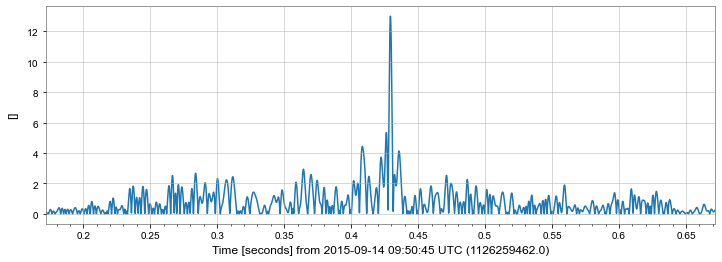

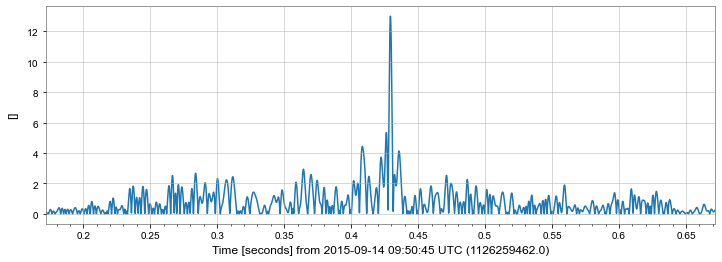

In [21]:
#numShifts = 1000 #Radius of sampling interval shifts from true time in which to search
H1_radius = 4096 #timesteps, should be greater than L1_radius
L1_radius = 1028 #timesteps

timestep = white_data_bp2.dt
H1_cropped = white_data_bp.copy().crop(tevent*units.s-H1_radius*timestep, tevent*units.s+H1_radius*timestep)
#H1_times = H1_cropped.times.value
L1_cropped = white_data_bp2.copy().crop(tevent*units.s-L1_radius*timestep, tevent*units.s+L1_radius*timestep)

snr = H1_cropped.correlate(L1_cropped).abs()
shiftSteps = snr.argmax() - H1_radius #Number of timesteps to add to L1 signal
shiftTime = shiftSteps*timestep
print(shiftSteps)
print(shiftSteps*timestep)
snr.plot()

#print(f"Searching in interval {timestep * 2 * numShifts} wide.")

#correlations = []
#L1_cropped.shift(-numShifts*timestep)
#print(L1_cropped.times[0])
#print(L1_cropped.times[-1])

#for i in range(numShifts * 2):
#    indicesH1 = np.where((H1_times >= L1_cropped.times[0]) & (H1_times <= L1_cropped.times[-1]))
#    correlations.append(np.multiply(H1_cropped.value[indicesH1], L1_cropped.value))
#    L1_cropped.shift(timestep)
    
#plt.plot(correlations)
#plt.show()
 

Based on the above, we need to shift the L1 signal back by 120 time steps (as in have the peaks happen 0.007 seconds later) for best match.

C:\Users\jade2\miniconda3\envs\8.s50\lib\site-packages\gwpy\plot\plot.py:276: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


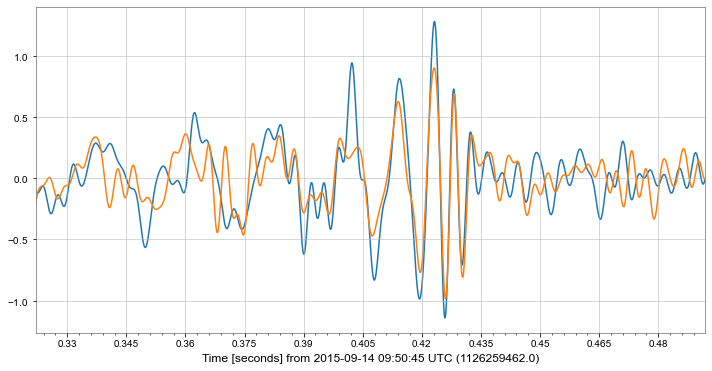

In [50]:
#apply optimal shift to white_data_bp2, i.e. L1 data
shifted_data_bp = white_data_bp.copy()
#shifted_data_bp.pad(((0, shiftSteps) if shiftSteps >= 0 else (-shiftSteps, 0)), mode = 'constant')
shifted_data_bp2 = white_data_bp2.copy()
#shifted_data_bp2.pad(((shiftSteps, 0) if shiftSteps >= 0 else (0, -shiftSteps)), mode = 'constant') #padding does not seem to work?
#print(shiftSteps)
#print(shifted_data_bp2)
shifted_data_bp2.shift('7.324ms')
shifted_data_bp2 *= -1 #seems needed a scaling by -1

plot = Plot(shifted_data_bp.crop(tevent-0.1, tevent+0.07), shifted_data_bp2.crop(tevent-0.1, tevent+0.07))
plot.show()

#plt.clf()

#shifted_data_bp.crop(tevent-0.17, tevent+0.13).plot()
#plt.ylabel('H1 strain, white + bp')

#shifted_data_bp2.plot()
#plt.ylabel('L1 strain, white + bp + shift + scale')
#plt.xlim(tevent-0.17, tevent+0.13)

#plt.show()

We see that the signals fit together quite well at the larger peaks. This is a good sign.

### Plot a q-transform of the data
Next we take a q-transform of the data and check the time variation of frequency.

C:\Users\jade2\miniconda3\envs\8.s50\lib\site-packages\gwpy\plot\plot.py:395: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = super().colorbar(mappable, **kwargs)


<Figure size 432x288 with 0 Axes>

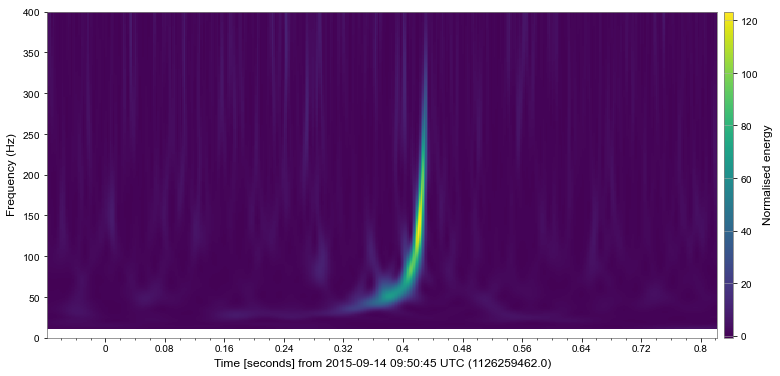

In [13]:
#----------------------------------------------------------------
# q-transform H1
#----------------------------------------------------------------

dt = 1  #-- Set width of q-transform plot, in seconds
hq = strain.q_transform(outseg=(tevent-dt, tevent+dt))

plt.clf()
fig = hq.plot()
ax = fig.gca()
fig.colorbar(label="Normalised energy")
ax.grid(False)
plt.xlim(tevent-0.5, tevent+0.4)
plt.ylim(0, 400)
plt.ylabel('Frequency (Hz)')
plt.show()

The yellow line is signal. Next we try developing an analytic model to describe this.

In [14]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

### Analytic model: frequency vs. time
Calculating the actual waveform requires complicated numerical simulations. However, we can use the basic knowledge of General Relativity (GR) and Newtonian mechanics to perform an approximate analytic calculation for the waveform. For an orbiting binary system ($m_{1}$ and $m_{2}$), according to GR the frequency ($\omega(t)$) of the GW radiation satisfies
\begin{equation}
\dot{\omega} = \frac{12}{5}2^{\frac{1}{3}}\left(\frac{G\mathcal{M}_{c}}{c^{3}}\right)^{\frac{5}{3}}\omega^{\frac{11}{3}}
\label{eq:wwdot}
\end{equation}
where $G$ and $c$ are gravitational constant and the speed of light respectively. $\mathcal{M}_{c}$ is so-called chirp mass, defined by
\begin{equation}
\mathcal{M}_{c} = \frac{(m_{1}m_{2})^{\frac{3}{5}}}{(m_{1}+{m_{2}})^{\frac{1}{5}}}
\label{eq:Mc}
\end{equation}
Integrating Eq.\eqref{eq:wwdot}, we can get
\begin{eqnarray}
\int\omega^{-\frac{11}{3}}d\omega &= \int\frac{12}{5}2^{\frac{1}{3}}\left(\frac{G\mathcal{M}_{c}}{c^{3}}\right)^{\frac{5}{3}}dt \\
    \Rightarrow \omega(t) &= \frac{5^{\frac{3}{8}}}{4}\left(\frac{c^{3}}{G\mathcal{M}_{c}}\right)^{\frac{5}{8}}\Delta t^{-\frac{3}{8}} \\
\end{eqnarray}
Now we get the time dependence of frequency. Considering
\begin{equation}\label{eq:msolar}
  \frac{GM_{\odot}}{c^{3}} \approx 4.93~\mathrm{\mu s}
\end{equation}
We have
\begin{equation}\label{eq:wtnum}
  \omega(t) = 948.5\left(\frac{M_{\odot}}{\mathcal{M}_{c}}\right)^{\frac{5}{8}}\left(\frac{1\:\mathrm{s}}{\Delta t}\right)^{\frac{3}{8}}\;\mathrm{[Hz\cdot rad]}
\end{equation}
Now let's plot this function and see how it looks like.

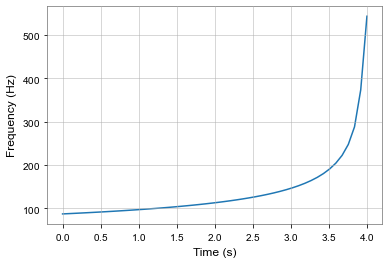

In [15]:
#----------------------------------------------------------------
# Frequency analytic
#----------------------------------------------------------------

def gwfreq(iM,iT,iT0):
    const = (948.5)*np.power((1./iM),5./8.) #solar mass is normalized as 1.
    output = const*np.power(np.maximum(iT0-iT, 3e-2),-3./8.) 
    return output

times = np.linspace(0., 4., 50)
freq = gwfreq(20, times, 4)

plt.clf()
plt.plot(times, freq)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

The shape is very similar to what we have seen in data. You can use the model to fit data as play, and we don't do it here. Next, we try building the analytic model of wave form.

### Analytic model: Wave form
Now, we build the waveform with the radiation power $dE(t)/dt$.
\begin{eqnarray}
f(t) &= A(t)\cos(\omega(t)\Delta t +\phi) \\
\label{eq:ft}    &\propto \frac{dE(t)}{dt}\cos(\omega(t)\Delta t +\phi) \\
\end{eqnarray}
With Newtonian mechanics, we know the energy of a binary orbit is
\begin{eqnarray}
E &= E_{\mathrm{k}} + E_{\mathrm{u}} \\
    &= \frac{1}{2}\mu\dot{r}^{2} + \frac{1}{2}\frac{m_{1}m_{2}}{m_{1}+m_{2}}\omega^{2}R^{2} - \frac{Gm_{1}m_{2}}{R} \\
\label{eq:Etot}    &= \frac{1}{2}\frac{m_{1}m_{2}}{m_{1}+m_{2}}\omega^{2}R^{2} - \frac{Gm_{1}m_{2}}{R} \\ 
\end{eqnarray}
The last step is because $\dot{r} = 0$. According to Kepler's third law,
\begin{equation}\label{eq:kepler}
  \omega^{2} = \frac{G(m_{1}+m_{2})}{R^{3}}
\end{equation}
Put \eqref{eq:kepler} into \eqref{eq:Etot} and substitute $R$, we have
\begin{eqnarray}
E &= -\frac{Gm_{1}m_{2}}{2R} \\
\label{eq:Ew}    &\propto \mathcal{M}_{c}^{\frac{5}{3}}\omega(t)^{\frac{2}{3}} \\
\end{eqnarray}
Perform derivatives on Eq.\eqref{eq:Ew},
\begin{eqnarray}
\frac{dE}{dt} &\propto \mathcal{M}_{c}^{\frac{5}{3}}\omega(t)^{-\frac{1}{3}}\dot{\omega} \\
\label{eq:dEdt}    &\propto \left(\mathcal{M}_{c}\omega(t)\right)^{\frac{10}{3}} \\
\end{eqnarray}
Put Eq.\eqref{eq:dEdt} into Eq.~\eqref{eq:ft}, we have the waveform
\begin{eqnarray}
\label{eq:fwt}
f(t) &= C\left(\mathcal{M}_{c}\omega(t)\right)^{\frac{10}{3}}\cos(\omega(t)\Delta t +\phi), \\
    \mathrm{where}\:\omega(t) &= 948.5\left(\frac{M_{\odot}}{\mathcal{M}_{c}}\right)^{\frac{5}{8}}\left(\frac{1\:\mathrm{s}}{\Delta t}\right)^{\frac{3}{8}}\;\mathrm{[Hz\cdot rad]} \\
\end{eqnarray}
and $C$ is a constant. This waveform amplitude is only supposed to work before merger ($t \leq t_{0}$), and we need to come up with a way to define the ringdown amplitude ($t > t_{0}$). The actual way to get the amplitude requires months of a super computer to build good templates. As a simple approximate solution, you can use a simple damping function (Here I use an exponential).<br>
<span style="color:#CF7A17;font-weight:bold">What you need to do: Build a function osc(t, Mc, t0, C, phi). It has the form as Eq.\eqref{eq:fwt} for $t \leq t_{0}$, but damp to vanish for $t > t_{0}$.</span>

In [53]:
#Outputs prediction of strain vs. time given chirp mass, merger time, and scaling + phase constants
# t : times, ndarray 1d
# Mc : chirp mass, single value
# t0 : event time, single value
# C : fit scale, single value
# phi : fit phase, single value
# decay: speed of exponential decay applied
def osc(t, Mc, t0, C, phi, decay = 563.85):
    #get predictions for each time in t
    return np.array([C * np.power(Mc*omega, 10/3) * np.cos(omega*(t0-time) + phi) * np.exp((t0-time)*decay) if time > t0 else C * np.power(Mc*omega, 10/3) * np.cos(omega*(t0-time) + phi) for time, omega in zip(t, gwfreq(Mc, t, t0))])

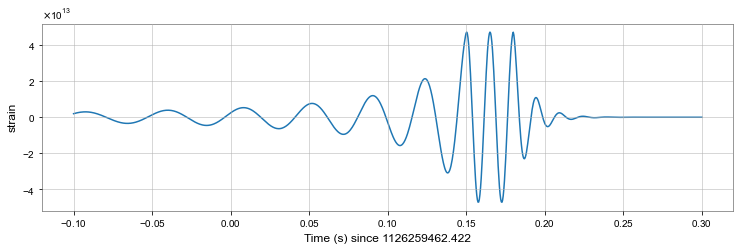

In [28]:
# Draw the function defined
times = np.linspace(-0.1, 0.3, 1000)
freq = osc(times, 30, 0.18, 1, 0.0, 100)
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(times, freq)
plt.xlabel('Time (s) since '+str(tevent))
plt.ylabel('strain')
plt.show()

Looks not bad. Now we use this function to fit the data.

In [29]:
# define osc_dif for lmfit::minimize()
def osc_dif(params, x, data, eps):
    iM=params["Mc"]
    iT0=params["t0"]
    norm=params["C"]
    phi=params["phi"]
    decay=params["decay"]
    val=osc(x, iM, iT0, norm, phi, decay)
    return (val-data)/eps

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 181
    # data points      = 4915
    # variables        = 5
    chi-square         = 0.56867254
    reduced chi-square = 1.1582e-04
    Akaike info crit   = -44542.0054
    Bayesian info crit = -44509.5052
##  Warning: uncertainties could not be estimated:
[[Variables]]
    Mc:     18.6826077 (init = 20)
    t0:     0.17787455 (init = 0.18)
    C:     -2.0864e-14 (init = 1)
    phi:   -1.4240e-10 (init = 0)
    decay:  563.851981 (init = 40)


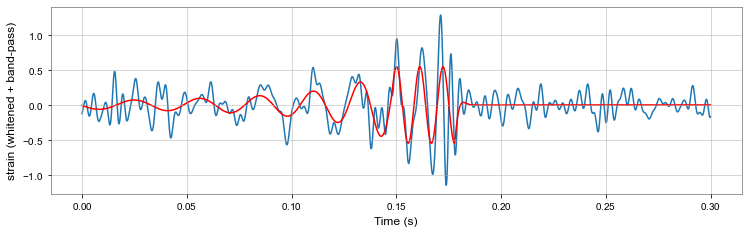

In [33]:
#----------------------------------------------------------------
# Fit
#----------------------------------------------------------------

sample_times = white_data_bp.times.value
sample_data = white_data_bp.value
indxt = np.where((sample_times >= (tevent-0.17)) & (sample_times < (tevent+0.13)))
x = sample_times[indxt]
x = x-x[0]
white_data_bp_zoom = sample_data[indxt]

plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(x, white_data_bp_zoom)
plt.xlabel('Time (s)')
plt.ylabel('strain (whitened + band-pass)')

import lmfit
from lmfit import Model, minimize, fit_report, Parameters

model = lmfit.Model(osc)
p = model.make_params()
p['Mc'].set(20)     # Mass guess
p['t0'].set(0.18)  # By construction we put the merger in the center
p['C'].set(1)      # normalization guess
p['phi'].set(0)    # Phase guess
p['decay'].set(40) # Expon. decay rate guess

unc = np.full(len(white_data_bp_zoom),20)
out = minimize(osc_dif, params=p, args=(x, white_data_bp_zoom, unc))
print(fit_report(out))
plt.plot(x, model.eval(params=out.params,t=x),'r',label='best fit')
plt.show()

With the simple analytic model, we actually caught the wave shape for $t<t_{0}$. The parameter gives the value $\mathcal{M}_{c}/M_{\odot}\sim 19$. The actual mass is $\sim 28$ (not too far!)

To get the actual form you need to do complicated numerical simulations. <br>
<span style="color:#CF7A17;font-weight:bold">What you need to do: load the template database, fit the data, and get more accurate parameters.</span>

In [ ]:
# to do

## Search signal in long time range
When we zoom in the data above, we look at the small range where the signal is. However in reality we don't know where the signal is in advance.<br>
<span style="color:#CF7A17;font-weight:bold">What you need to do: develop a machinery to search for GW events across a long time range</span>.<br>

In [54]:
#osc_dif without decay fitting
def osc_dif_noDecay(params, x, data, eps):
    iM=params["Mc"]
    iT0=params["t0"]
    norm=params["C"]
    phi=params["phi"]
    val=osc(x, iM, iT0, norm, phi)
    return (val-data)/eps

In [68]:
#Matched filtering; use quality of fit between template and whitened bandpassed signal
#Split range into overlapping segments of 2x length of approx characteristic length of template
#Run fit for each, store significance

sample_times = white_data_bp.times.value - white_data_bp.times.value[0] #seconds
sample_data = white_data_bp.value #whitened strain values

#Get window size
samplingInterval = sample_times[1] #seconds between samples
templateLength = 0.3 #seconds
windowRadius = int(templateLength/samplingInterval) #number of samples in half a window, and spacing between windows
numWindows = len(sample_times)//windowRadius - 2
print("Fitting with {0} samples in each window over {1} windows".format(2*windowRadius, numWindows))

#Perform fitting on each window

template = lmfit.Model(osc)
p = model.make_params()
#Set initial guess parameters
p['Mc'].set(20)     # Mass guess
p['t0'].set(0.18)  # By construction we put the merger in the center
p['C'].set(1)      # normalization guess
p['phi'].set(0)    # Phase guess
eps = np.full(2*windowRadius, 20)

windowStartTimes = [sample_times[(i+1)*windowRadius] for i in range(numWindows)]
chi2s = []
for i in range(numWindows):
    #First window starts at windowRadius*samplingInterval seconds
    windowTimes = sample_times[(i+1)*windowRadius:(i+3)*windowRadius] 
    windowData = sample_data[(i+1)*windowRadius:(i+3)*windowRadius]
    #Fit
    fit = minimize(osc_dif_noDecay, params=p, args=(windowTimes, windowData, eps)) #MinimizerResult
    chi2s.append(fit.chisqr)
    print(f"Fitting {i} of {numWindows}\r", end="")
    
#Refinement stage?
#Do peak-finding, assume only one GW event at most, so just take max and check if high enough.
#Take smaller window intervals in that area

Fitting with 9830 samples in each window over 104 windows


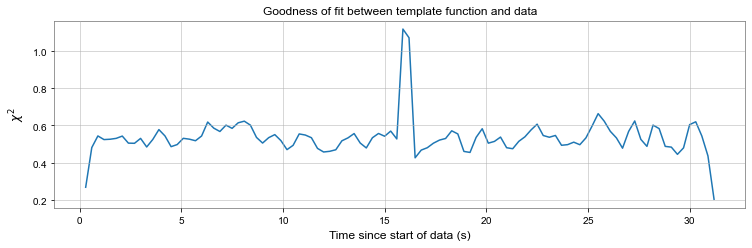

In [67]:
#Plot result
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(windowStartTimes, chi2s)
plt.title('Goodness of fit between template function and data')
plt.xlabel('Time since start of data (s)')
plt.ylabel('$\chi^2$')
plt.show()

We can see the $\chi^{2}$ value is significantly higher around the event time.

In [30]:
#More efficient signal finding?
#For a range of chirp masses, calculate template function
#Run cross-correlation on each, then plot results; center of peak in time and chirp mass is candidate for signal

## More things to explore
Now you have known the basic method to analyze a particular GW event. Now you can explore more interesting things.<br>
  * <span style="color:#CF7A17;font-weight:bold">Check and quantify the consistence between detectors (H1 and V1);</span>
  * <span style="color:#CF7A17;font-weight:bold">Load the template database, fit the data, and get more accurate parameters;</span>
  * <span style="color:#CF7A17;font-weight:bold">Determine how far the source of GW is away;</span>
  * <span style="color:#CF7A17;font-weight:bold">Explore more events;</span>
    * <span style="color:#CF7A17;font-weight:bold">Data of other events can be found [here](https://www.gw-openscience.org/eventapi/html/allevents/).</span>
  * <span style="color:#CF7A17;font-weight:bold">How to determine if the source is black hole merger or neutron star merger or other source?</span>